## Ομάδα #75 
## Νικόλαος Μανιάτης (ΑΜ: 03400097) - Φίλιππος Μαυρεπής (ΑΜ: 03400098)

##### Datasets: S12,	B04,	119

### Dataset B04

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import preprocessing

**Dataset Abstract**
NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.

**Attribute Information:**

This problem has the following inputs:
1. Frequency, in Hertz.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:  
6. Scaled sound pressure level, in decibels.

It is obvious all attributes are numerical.

In [17]:
features = ['freq','angle','length','velocity','thickness','pressure']
df = pd.read_table('./datasets/airfoil_self_noise.dat',names = features )
print(df.shape)
df.head()

(1503, 6)


,freq,angle,length,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


There are no null values.

In [18]:
df.isna().sum()

freq         0
angle        0
length       0
velocity     0
thickness    0
pressure     0
dtype: int64

Correlation Matrix:

In [19]:
df.corr()

,freq,angle,length,velocity,thickness,pressure
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


### Train-Test-Split (70\% Train - 30\% Test) and Min-Max Scaling

Πρώτα εκτελούμε το διαχωρισμό test-train και μετά το min-max scaling ώστε να μην έχουμε διαρροή πληροφορίας από το test set μέσα στο train set (π.χ. πληροφορία από το μέσο όρο).

In [32]:
features = df.copy()
features = features.drop(['pressure'],axis=1)
output = df[['pressure']]

In [33]:
X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc = train_test_split(features,output, test_size=0.3, random_state=75)

In [38]:
scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()

train_X = scaler_x.fit_transform(X_train_unsc)
test_X = scaler_x.fit_transform(X_test_unsc)

train_y = scaler_y.fit_transform(np.array(y_train_unsc).reshape(-1,1))
train_y = train_y.reshape(-1)
test_y = scaler_y.fit_transform(np.array(y_test_unsc).reshape(-1,1))
test_y = test_y.reshape(-1)

In [39]:
print('X train shape:',train_X.shape)
print('X test shape:',test_X.shape)
print('y train shape:',train_y.shape)
print('y test shape:',test_y.shape)

X train shape: (1052, 5)
X test shape: (451, 5)
y train shape: (1052,)
y test shape: (451,)


**Θα ξεκινήσουμε με δύο απλούς Regressors, τον Ordinary Least Squares και τον Polynomial Regressor. Αυτοί δεν επιδέχονται κάποιου είδους optimization (εκτός από την τάξη του πολυωνύμου) οπότε τους παρουσιάζουμε στην αρχή, πριν συνεχίσουμε με πιο πολύπλοκους αλγόριθμους.**

## Ordinary Least Squares

In [40]:
reg = LinearRegression().fit(X_train, y_train)

In [41]:
reg.score(X_test, y_test)

0.48701529018157896

## Polynomial Regression

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [48]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
...                   ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train,y_train)
model.named_steps['linear'].coef_
model.score(X_test, y_test)

0.6223336446282257

Εύρεση βέλτιστου βαθμού πολυωνύμου:

degree of polynomial = 1 and score is 0.48701529018065426
degree of polynomial = 2 and score is 0.6223336446282257
degree of polynomial = 3 and score is 0.7209720262016102


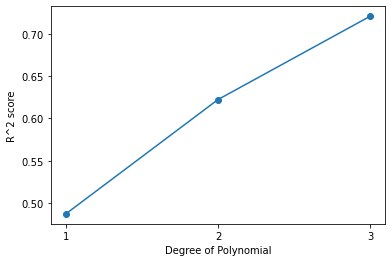

In [27]:
scores = []
ais = []
for i in range(1,4):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),
    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    model = model.fit(X_train,y_train)
    model.named_steps['linear'].coef_
    print('degree of polynomial = {} and score is {}'.format(i,model.score(X_test, y_test)))
    scores.append(model.score(X_test,y_test))
    ais.append(i)
plt.plot(ais,scores)
plt.scatter(ais,scores)
plt.ylabel('R^2 score')
plt.xlabel('Degree of Polynomial')
plt.xticks([1,2,3])
plt.yticks()
plt.show()

Παρατηρούμε ότι βέλτιστος βαθμός πολυωνύμου είναι $n=3$ με $R^2 = 72.1 \%$.  
Αυτό είναι ένα πολύ καλό αποτέλεσμα αν λάβουμε υπόψη τη διαστατικότητα των δεδομένων μας (5 μεταβλητές) για ένα τόσο απλό μοντέλο.

# Main Problem

Οι Regressors με τους οποίους θα ασχοληθούμε είναι οι εξής:
- Linear Regressor (LR)
- Ridge Regressor (RD)
- Lasso Regressor (LAS)
-  Decision Trees Regressor (DT)
-  Multi Layer Perceptron Regressor (MLP)
-  Multi Layer Perceptron Regressor (but with hidden layers) (DMLP)
-  Support Vector Regressor (SVR)
-  Extra Trees Regressor (ET)
-  XGBoost Regressor (XGB)

In [54]:
#instantiate all random components with team number as seed - reproducible results
models = []
models.append(('LR', LinearRegression()))
models.append(('RD', Ridge()))
models.append(('LAS', Lasso()))
models.append(('DT', DecisionTreeRegressor(random_state=75)))
models.append(('MLP', MLPRegressor(random_state=75)))#Default Hidden Layers
models.append(('DMLP', MLPRegressor(random_state=75, hidden_layer_sizes=(100,100))))#With 1 extra hidden layer, default is (100,). (Deep Multi Layer Perceptron).
models.append(('SVR',SVR()))
models.append(('ET',ExtraTreesRegressor(random_state=75)))
models.append(('XGB', XGBRegressor(random_state=75)))

In [133]:
#helper function to plot models in train and test sets for easier comparison
def compare_models(trainX,trainY,testX,testY,models):
    print('\nCompare Multiple Regressors:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
    names = []
    tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for name, model in models:
        model.fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(model, trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(model,testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':name,'Dataset':'Train','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':name,'Dataset':'Test','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    g = sns.catplot(x = 'Name', y='Score',hue = 'Dataset',data=tempdf, kind='bar',height=7.5, aspect=11.7/7.5)
    g.set_xticklabels(rotation=30)
    return tempdf,plt.show()


Compare Multiple Regressors:

K-Fold Cross-Validation Accuracy:



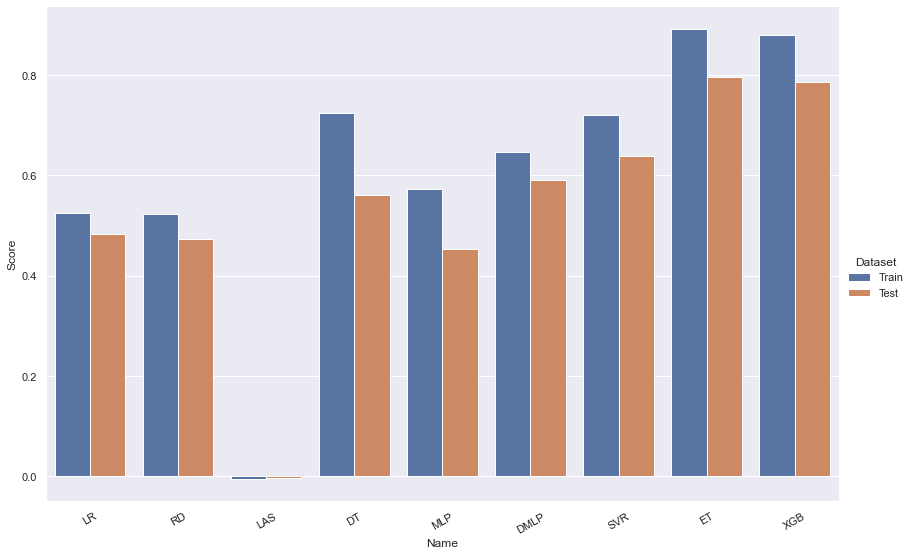

    Name Dataset     Score    St.Dev
0     LR   Train  0.524293  0.022378
1     LR    Test  0.483958  0.010032
2     RD   Train  0.522606  0.019062
3     RD    Test  0.473472  0.020209
4    LAS   Train -0.004726  0.000553
5    LAS    Test -0.003199  0.000080
6     DT   Train  0.724711  0.018531
7     DT    Test  0.561512  0.030118
8    MLP   Train  0.573983  0.033982
9    MLP    Test  0.452736  0.026096
10  DMLP   Train  0.645791  0.020936
11  DMLP    Test  0.590723  0.002015
12   SVR   Train  0.719682  0.008204
13   SVR    Test  0.638348  0.003131
14    ET   Train  0.891462  0.015224
15    ET    Test  0.795614  0.013143
16   XGB   Train  0.880487  0.006803
17   XGB    Test  0.786158  0.009417
Wall time: 5.29 s


In [134]:
%%time
models_df,_ = compare_models(train_X, train_y, test_X, test_y, models)
print(models_df)

**About LASSO having a negative score on both sets**:  
It's not impossible to get an $R^2$ value less than 0.  
$R^2$ is a metric used to measure the performance of a regressor. The optimal score of $R^2$ metric is 1. If any regressor predicts a constant value, you should expect an $R^2$ score of 0 for that regressor, but unexpectedly, you can get worse performance than that.  
$R^2$ is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

## Optimization for each regressor individually

Στα πιο απλά μοντέλα, όπου τα fit είναι πιο 'εύκολα' υπολογιστικά, χρησιμοποιούμε 10-fold cross validation στο grid search, ενώ στα πιο περίπλοκα 2-folds ώστε να είναι πιο οικονομικό.

Σε όλα τα Grid Search που εκτελούμε, φροντίζουμε να εμπεριέχονται οι default υπερπαράμετροι του κάθε Regressor, ώστε το υποτιθέμενο βέλτιστο μοντέλο να μην έχει χειρότερη απόδοση από ότι το default.  
**Σημαντική Σημείωση**: Όταν επιστρέφουμε τον best estimator μετά από κάθε grid search, αυτό μας επιστρέφει μόνο τις τιμές οι οποίες διαφοροποιούνται από τις default.

In [56]:
models_opt = []

#### 1. Linear Regression: Has no hyperparameters to optimize.

In [57]:
LR = LinearRegression()
models_opt.append(('LD*',LR))

#### 2. Ridge Regression

In [58]:
%%time
Ridge_ = GridSearchCV(Ridge(), param_grid = {'alpha':[i for i in np.arange(0,1,0.05)],\
                                                'solver':('svd', 'cholesky', 'lsqr')},cv=KFold(n_splits=2,shuffle=True,random_state = 75))
Ridge_.fit(train_X,train_y)

Wall time: 293 ms


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0, 0.05, 0.1, 0.15000000000000002, 0.2,
                                   0.25, 0.30000000000000004,
                                   0.35000000000000003, 0.4, 0.45, 0.5, 0.55,
                                   0.6000000000000001, 0.65, 0.7000000000000001,
                                   0.75, 0.8, 0.8500000000000001, 0.9,
                                   0.9500000000000001],
                         'solver': ('svd', 'cholesky', 'lsqr')})

In [59]:
Ridge_.best_estimator_

Ridge(alpha=0.2, solver='svd')

**Σημείωση:** Από εδώ και πέρα θα ορίζουμε ξανά τον best estimator, χρησιμοποιώντας τις βέλτιστες υπερπαραμέτρους. Έτσι, όταν θέλουμε να ξαναδουλέψουμε στο πρόβλημα, να έχουμε ήδη ορατή την πληροφορία για το σύνολο τον βέλτιστων υπερπαραμέτρων και να μην χρειάζεται να ξανατρέξουμε το grid search που πολλές φορές παίρνει αρκετή ώρα.

In [72]:
Ridge_opt = Ridge(alpha=0.2,solver = 'svd')
Ridge_opt.fit(train_X,train_y)

Ridge(alpha=0.2, solver='svd')

In [61]:
models_opt.append(('RD*',Ridge_opt))

Σημαντικότερη παράμετρος: $\alpha$ καθώς είναι το μέτρο της ποινής (L1) που εφαρμόζει στο regression.

#### 3. Lasso Regression

In [69]:
%%time
Lasso_ = GridSearchCV(Lasso(), param_grid = {'alpha':[0.0001, 0.0002,0.001,0.01,0.1,0.2,0.5,0.8,1],\
                                            'max_iter':[k for k in np.arange(1000,10000,500)],
                                            'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]},cv=KFold(n_splits=10,shuffle=True,random_state = 75),verbose=2,n_jobs=-1)
Lasso_.fit(train_X,train_y)

Fitting 10 folds for each of 1134 candidates, totalling 11340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    2.7s


Wall time: 5.24 s


[Parallel(n_jobs=-1)]: Done 11072 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 11340 out of 11340 | elapsed:    5.0s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=75, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0002, 0.001, 0.01, 0.1, 0.2, 0.5,
                                   0.8, 1],
                         'max_iter': [1000, 1500, 2000, 2500, 3000, 3500, 4000,
                                      4500, 5000, 5500, 6000, 6500, 7000, 7500,
                                      8000, 8500, 9000, 9500],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                 1e-08]},
             verbose=2)

In [70]:
Lasso_.best_estimator_

Lasso(alpha=0.0001, tol=1e-08)

In [67]:
Lasso_opt = Lasso(alpha=0.0001,tol=1e-8)
Lasso_opt.fit(train_X,train_y)

Lasso(alpha=0.0001, tol=1e-08)

In [68]:
models_opt.append(('LAS*',Lasso_opt))

Σημαντικότερη παράμετρος: $\alpha$ καθώς είναι το μέτρο της ποινής (L2) που εφαρμόζει στο regression.

#### 4. Decision Trees Regressor

In [74]:
%%time
DT_ = GridSearchCV(DecisionTreeRegressor(), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': [None,1,2,3,4,5,6,7,8,9,10],
                                                         "min_samples_split":range(2,10),
                                                         "min_samples_leaf":range(1,5)}
                                                          ,n_jobs = -1,cv=KFold(n_splits=10,shuffle=True,random_state = 75),verbose=2)
DT_.fit(train_X, train_y)

Fitting 10 folds for each of 704 candidates, totalling 7040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:    0.7s


Wall time: 8.97 s


[Parallel(n_jobs=-1)]: Done 7040 out of 7040 | elapsed:    8.8s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=75, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)},
             verbose=2)

In [75]:
DT_.best_estimator_

DecisionTreeRegressor(criterion='mae')

In [76]:
DT_opt = DecisionTreeRegressor(criterion='mae')
DT_opt.fit(train_X,train_y)

DecisionTreeRegressor(criterion='mae')

In [77]:
models_opt.append(('DT*',DT_opt))

Σημαντικότεροι παράμετροι: το min_samples_split, το max_depth και το κριτήριο mse ή mae.

**5(a). Multi Layer Perceptron Regressor (no-hidden layers)**

In [75]:
%%time
MLP_ = GridSearchCV(MLPRegressor(random_state=75), param_grid={'activation' : ['tanh','relu'],
                                                'solver':['sgd','adam'],
                                                'alpha':[1e-5,1e-4,1e-3],
                                                'learning_rate':['constant','adaptive'],
                                                'max_iter':[100,200,1000],
                                                'learning_rate_init':[0.0001,0.001,0.003,0.005,0.01]},
                                                 n_jobs = -1,cv=KFold(n_splits=2,shuffle=True,random_state = 75))
MLP_.fit(train_X,train_y)

Wall time: 33.9 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MLPRegressor(random_state=75), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [1e-05, 0.0001, 0.001],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.0001, 0.001, 0.003, 0.005,
                                                0.01],
                         'max_iter': [100, 200, 1000],
                         'solver': ['sgd', 'adam']})

In [99]:
MLP_.best_estimator_

MLPRegressor(learning_rate_init=0.01, max_iter=100, random_state=75)

In [79]:
MLP_opt = MLPRegressor(random_state=75, max_iter=100,learning_rate_init=0.01)
MLP_opt.fit(train_X,train_y)

MLPRegressor(learning_rate_init=0.01, max_iter=100, random_state=75)

In [80]:
models_opt.append(('MLP*',MLP_opt))

Το MLP όντας νευρωνικό δίκτυο, έχει πολλές σημαντικές παραμέτρους οι οποίες πρέπει να γίνουν fine tuning ταυτόχρονα για τη μέγιστη απόδοση. Όπως το learning rate, ο solver, η activation function κτλ.

**5(b). Multi Layer Perceptron (with hidden layers)**

Εδώ κρατάμε τις βέλτιστες υπερπαραμέτρους που βρέθηκαν από το παραπάνω Grid Search και τις χρησιμοποιούμε για να κάνουμε κι'άλλο Grid Search, αυτή τη φορά μαζί με hidden layers.

In [102]:
%%time
MLP_2 = GridSearchCV(MLPRegressor(random_state=75), 
                                 param_grid={'max_iter':[100,200,1000],'learning_rate_init':[0.0001,0.001,0.005],
                                'hidden_layer_sizes':[(256, 256, 256),(512,256,128),(64,32,8)]},n_jobs = -1,
                                    cv=KFold(n_splits=2,shuffle=True,random_state = 75))
MLP_2.fit(train_X,train_y)

Wall time: 34.4 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=MLPRegressor(random_state=75), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(256, 256, 256),
                                                (512, 256, 128), (64, 32, 8)],
                         'learning_rate_init': [0.0001, 0.001, 0.005],
                         'max_iter': [100, 200, 1000]})

In [103]:
MLP_2.best_estimator_

MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)

In [81]:
MLP_2_opt = MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)
MLP_2_opt.fit(train_X,train_y)

MLPRegressor(hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.005,
             max_iter=100, random_state=75)

In [82]:
models_opt.append(('DMLP*',MLP_2_opt))

**6. Support Vector Regression** 

In [35]:
%%time
param = {'kernel' : ('poly', 'rbf','sigmoid'),'C' : [1,5],'degree' : [3,8],'coef0' : [0.01,0.001],'gamma' : ['scale','auto']}
#defaults: kernel=rbf, C=1.0, degree=3, coef0=0.0, gamma=scale
SVR_ = GridSearchCV(SVR(),param_grid = param,cv = KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
SVR_.fit(train_X,train_y)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of  96 | elapsed:    0.2s remaining:    0.0s


Wall time: 9.65 s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    9.5s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5], 'coef0': [0.01, 0.001], 'degree': [3, 8],
                         'gamma': ['scale', 'auto'],
                         'kernel': ('poly', 'rbf', 'sigmoid')},
             verbose=2)

In [36]:
SVR_.best_estimator_

SVR(C=5, coef0=0.01)

Τώρα ξέρουμε ότι ο καλύτερος kernel είναι ο RBF οπότε θα κάνουμε άλλο ένα GridSearch πιο ειδικό.

In [57]:
%%time
param = {'C' : [1,5,5.5,6,7,7.5,8],'degree' : [3,8],'coef0' : [10,5,1,0.5,0.1,0.05],'tol':[1e-2,1e-3,1e-4]}
#defaults: kernel=rbf, C=1.0, degree=3, coef0=0.0, gamma=scale
SVR_ = GridSearchCV(SVR(),param_grid = param,cv = KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
SVR_.fit(train_X,train_y)

Fitting 2 folds for each of 252 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s


Wall time: 1.11 s


[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:    1.0s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 5.5, 6, 7, 7.5, 8],
                         'coef0': [10, 5, 1, 0.5, 0.1, 0.05], 'degree': [3, 8],
                         'tol': [0.01, 0.001, 0.0001]},
             verbose=2)

In [59]:
SVR_.best_estimator_

SVR(C=7, coef0=10)

In [83]:
SVR_opt = SVR(C=7, coef0 = 10)
SVR_opt.fit(train_X,train_y)

SVR(C=7, coef0=10)

In [84]:
models_opt.append(('SVR*',SVR_opt))

Μέγιστη σημασία στο support vector regression έχει η επιλογή κατάλληλου Kernel.

**7. Extra Trees Regressor**

In [82]:
%%time
ET_ = GridSearchCV(ExtraTreesRegressor(random_state=75), param_grid = {'criterion': ['mse', 'mae'],
                                                          'max_depth': [None,1,2],
                                                         "min_samples_split":[1,2,3],
                                                         "min_samples_leaf":[1,2,3]},
                                                           cv=KFold(n_splits=10,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
ET_.fit(train_X, train_y)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 509 tasks      | elapsed:   21.7s


Wall time: 24.4 s


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   24.1s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=75, shuffle=True),
             estimator=ExtraTreesRegressor(random_state=75), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [None, 1, 2],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3]},
             verbose=2)

In [83]:
ET_.best_estimator_

ExtraTreesRegressor(random_state=75)

Παρατηρούμε ότι ο Extra Trees Regressor προτιμάει τις default παραμέτρους του.

In [85]:
ET_opt = ExtraTreesRegressor(random_state=75)
ET_opt.fit(train_X,train_y)

ExtraTreesRegressor(random_state=75)

In [86]:
models_opt.append(('ET*',ET_opt))

Ομοίως με τα Decision Trees μεγάλο ρόλο παίζει η παράμετρος με την οποία γίνεται η απόφαση (gini ή entropy) καθώς και min_samples_split και το max_depth.

**8. XG Boost Regressor**

In [87]:
%%time
XGB_ = GridSearchCV(XGBRegressor(random_state=75,n_jobs=-1),
                                                            param_grid  = {'booster':['gbtree','dart'],
                                                            'min_child_weight':[1,5], 
                                                            'gamma':[0,1,2,3,4],  
                                                            'subsample':[0.5,1],
                                                            'max_depth': [5,6,7],
                                                             'n_estimators':[100,500,1000]},
                                                            cv=KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
XGB_.fit(train_X, train_y)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.4min finished


Wall time: 4min 24s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monot...
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=75,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_m

In [88]:
XGB_.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
XGB_opt = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1,monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
%%time
XGB_ = GridSearchCV(XGBRegressor(random_state=75,n_jobs=-1),
                                                            param_grid  = {'subsample':[0.2,0.3,0.4,0.5,0.6],
                                                            'max_depth': [3,4,5,6],
                                                            'reg_alpha':[0,0.1,0.5,1],
                                                             'reg_lambda':[1,1.5,3,5]},
                                                            cv=KFold(n_splits=2,shuffle=True,random_state = 75),n_jobs=-1,verbose=2)
XGB_.fit(train_X, train_y)

Fitting 2 folds for each of 320 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   17.7s finished


Wall time: 17.9 s


GridSearchCV(cv=KFold(n_splits=2, random_state=75, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=75,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                        

In [96]:
XGB_.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
%%time
XGB_opt = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
XGB_opt.fit(train_X,train_y)

Wall time: 138 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=75,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [125]:
models_opt.append(('XGB*',XGB_opt))

O XGBoost καθώς είναι επικίνδυνος στο overfitting, μεγάλη σημασία έχουν οι παράμετροι max_depth, min_child_weight και gamma διότι ελέγχουν την πολυπλοκότητα του μοντέλου.

In [165]:
def compare_models_final(trainX,trainY,testX,testY,models,modelsopt,tempdf):
    print('\nCompare Multiple Regressors:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    
#     tempdf = pd.DataFrame(columns=['Name','Dataset','Score','St.Dev'])
    for model, modelopt in zip(models,modelsopt):
        modelopt[1].fit(trainX,trainY)
        kfold = KFold(n_splits=2,shuffle=True,random_state = 75)
        train_accuracy_results = cross_val_score(modelopt[1], trainX,trainY, cv=kfold)
        test_accuracy_results = cross_val_score(modelopt[1],testX,testY,cv=kfold)
        tempdf = tempdf.append({'Name':model[0],'Dataset':'Train-opt','Score':train_accuracy_results.mean(),
                               'St.Dev':train_accuracy_results.std()},ignore_index=True)
        tempdf = tempdf.append({'Name':model[0],'Dataset':'Test-opt','Score':test_accuracy_results.mean(),
                               'St.Dev':test_accuracy_results.std()},ignore_index=True)
    tempdf['Percent Score(%)'] = 100*tempdf['Score']
    print('Models with default hyperparameters:')
    print(tempdf.loc[:17,:])
    print('Models after hyperparameter optimization:')
    print(tempdf.loc[18:,:])
    g = sns.catplot(x = 'Name', y='Percent Score(%)',hue = 'Dataset',data=tempdf, kind='bar',height=8.27, aspect=11.7/8.27)
    g.set_xticklabels(rotation=30)
    g.set(yticks=np.arange(0,90,10))
    return tempdf,plt.show()

# Final Results


Compare Multiple Regressors:

K-Fold Cross-Validation Accuracy:

Models with default hyperparameters:
    Name Dataset     Score    St.Dev  Percent Score(%)
0     LR   Train  0.524293  0.022378         52.429282
1     LR    Test  0.483958  0.010032         48.395821
2     RD   Train  0.522606  0.019062         52.260580
3     RD    Test  0.473472  0.020209         47.347213
4    LAS   Train -0.004726  0.000553         -0.472610
5    LAS    Test -0.003199  0.000080         -0.319950
6     DT   Train  0.724711  0.018531         72.471080
7     DT    Test  0.561512  0.030118         56.151249
8    MLP   Train  0.573983  0.033982         57.398279
9    MLP    Test  0.452736  0.026096         45.273615
10  DMLP   Train  0.645791  0.020936         64.579134
11  DMLP    Test  0.590723  0.002015         59.072253
12   SVR   Train  0.719682  0.008204         71.968240
13   SVR    Test  0.638348  0.003131         63.834776
14    ET   Train  0.891462  0.015224         89.146186
15    ET    Test 

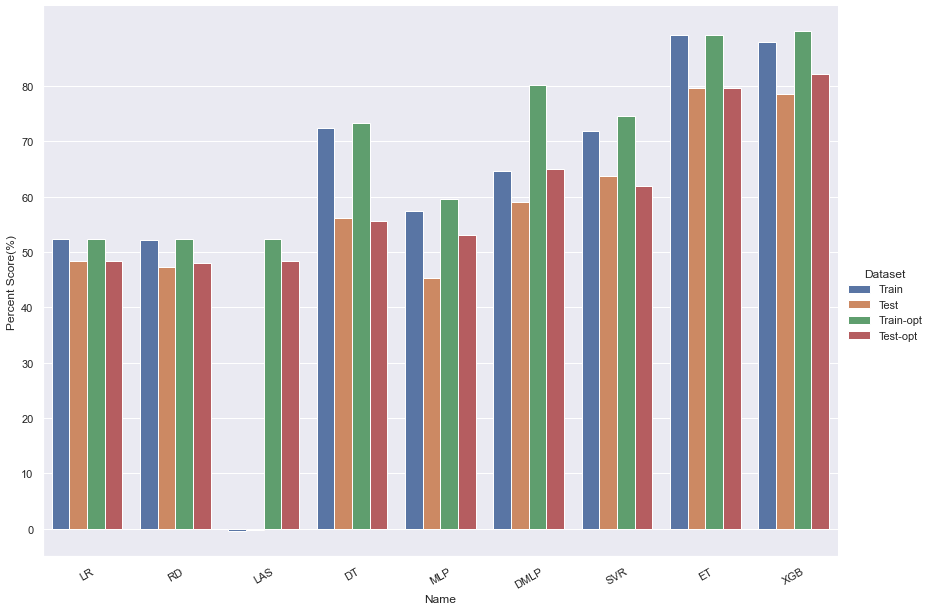

Wall time: 19.5 s


In [166]:
%%time
final_df,_ = compare_models_final(train_X,train_y,test_X,test_y,models,models_opt,models_df)

In [169]:
change = pd.DataFrame(columns=['Name','Dataset','ScoreChange'])
for i in range(0,18):
    change = change.append({'Name':final_df.Name[i],'Dataset':final_df.Dataset[i],'ScoreChange':round(final_df.Score[i+18]-final_df.Score[i],2)},ignore_index=True)
change['Per'] = 100*change['ScoreChange']
change

,Name,Dataset,ScoreChange,Per
0,LR,Train,0.00,0.0
1,LR,Test,0.00,0.0
2,RD,Train,0.00,0.0
3,RD,Test,0.01,1.0
4,LAS,Train,0.53,53.0
5,LAS,Test,0.49,49.0
6,DT,Train,0.01,1.0
7,DT,Test,-0.01,-1.0
8,MLP,Train,0.02,2.0
9,MLP,Test,0.08,8.0


### Πίνακας μεταβολής επίδοσης των αλγορίθμων μετά τη βελτιστοποίησή τους


Text(0.5, 0.98, 'Score Change after hyperparameter optimization for each Regressor')

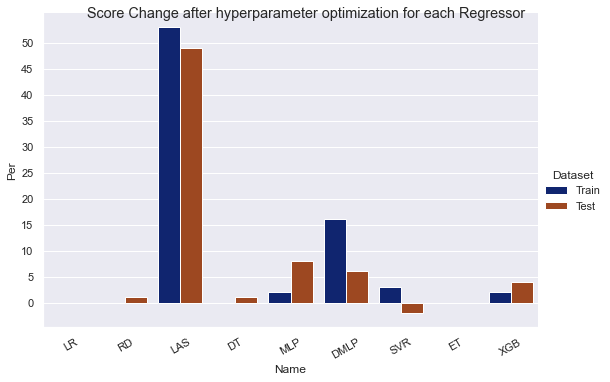

In [162]:
g = sns.catplot(x = 'Name', y='Per',hue = 'Dataset',data=change, kind='bar',height=5,aspect=1.5, palette='dark')
g.set_xticklabels(rotation=30)
g.set(yticks=np.arange(0,53,5))
g.fig.suptitle('Score Change after hyperparameter optimization for each Regressor')

### Σχόλια

 - Παρατηρούμε ότι στις περιπτώσεις Ridge και Lasso Regression το γεγονός ότι $\alpha\rightarrow 0$, σημαίνει ότι το πρόβλημά μας τείνει σε αυτό της απλής γραμμικής παλινδρόμησης επομένως παίρνουμε τους ίδιους συντελεστές με αυτό, γιαυτό και οι 2 τιμές του $R^2$ συγκλίνουν προς αυτό της γραμμικής παλινδρόμησης.
 - Στα Decision Trees βλέπουμε μια μικρή αύξηση της τάξης του 1\% στο test set μετά το optimization.
 - Το Multi Layer Perceptron χωρίς τα hidden layers, εμφανίζει μια 2\% αύξηση στο train set και 8\% αύξηση στο test set, δηλαδή μπορεί και γενικεύει καλύτερα.  
 - Το Default Multi Layer Perceptron όμως με 1 παραπάνω hidden layer, εμφανίζει ήδη by default λίγο μεγαλύτερη ακρίβεια από το αρχικό, λόγω της ικανότητας του να αποθηκεύει περισσότερη πληροφορία, και μετά το optimization όπου έχουμε 3 hidden layers με 512, 256 και 128 παραμέτρους αντίστοιχα, έχουμε 16\% παραπάνω accuracy στο train set και 6\% στο test set.
 - Το MLP με τα hidden layers έχει 10\% παραπάνω απόδοση από ότι αυτό χωρίς.
 - O SVR μετά το optimization εμφανίζει 3\% αύξηση στο train set και 2\% μείωση στο test set. Αυτό είναι μια περίπτωση overfitting.
 - O Extra Trees Regressor μετά το Grid Search δείχνει ότι προτιμάει τις default υπερπαραμέτρους του, επομένως δεν έχει καμία αλλαγή. Αυτό δεν σημαίνει ότι αυτές είναι οι βέλτιστοι υπερπαράμετροι, για να βρεθούν όμως, πρέπει να επεκταθεί το εύρος των υπερπαραμέτρων που ψάχνουμε.
 - Ο XGBoost Regressor μετά την βελτιστοποίηση δείχνει 2\% αύξηση στο train set και 4\% αύξηση στο test set, και είναι ο πιο ακριβής regressor στο σύνολο όλων, με test set accuracy 82\%.
 - Στα περισσότερα κελιά που υπάρχει ενδιαφέρον για το χρόνο εκτέλεσης έχει προστεθεί η built-in magic command `%%time` ώστε να φαίνεται ο χρόνος εκτέλεσης. Για όλους τους υπολογισμούς χρησιμοποιήθηκαν jupyter notebooks σε local runtime με επεξεργαστή i7-9th gen. Στις πιο απαιτητικές εργασίες, δηλαδή στα Grid Search, προστέθηκε η εντολή `n_jobs=-1` ώστε να εκτελούνται υπολογισμοί εν παραλλήλω, αξιοποιώντας και τα 12 threads του επεξεργαστή. 